In [1]:
!pip install gitpython
import sys
import git

In [2]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  from google.colab import drive
  drive.mount('/content/drive')
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session11'
  sys.path.append(module_path)
  print(sys.path)

# import sys
# import git
# if 'google.colab' in sys.modules:
#   #Add the directory containing your module to the Python path
#   from google.colab import drive

#   print("Mount the drive")
#   drive.mount('/content/drive')
#   module_path = '/content/drive/MyDrive/Colab_Notebooks/Session11-Git'


#   print("Remove old ERA2-master")
#   !rm -r /content/ERA2-Master

#   print("Downloading repository on Colab...")
#   !git clone "https://github.com/Shivdutta/ERA2-Master.git"

#   print("Import files from the downloaded repository")
#   !cp -rf /content/ERA2-Master/* /content/drive/MyDrive/Colab_Notebooks/Session11-Git/

#   print("Setting system path")
#   module_path = '/content/drive/MyDrive/Colab_Notebooks/Session11-Git'
#   sys.path.append(module_path)

#   print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session11']


## Import Modules

In [3]:
# Import all the required modules
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Install Albumentation library
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Install LR finder
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

# Install GradCam
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## Dataset Analysis

## Extract and Load the Data

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


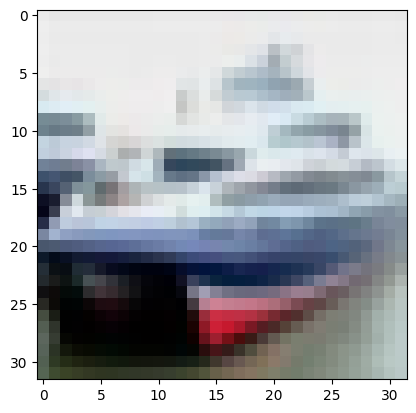

In [5]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Visualize Training Data

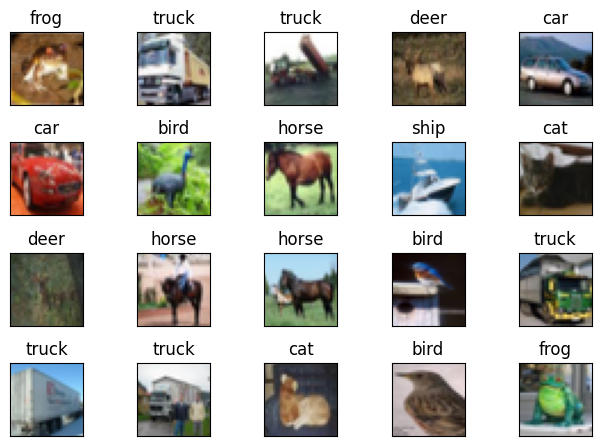

In [6]:
from utils import display_cifar_data_samples

DISPLAY_SAMPLES = 20
sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

## Transformations

In [7]:
from datasets import TransformedDataset
from augmentations import train_set_transforms, test_set_transforms

# Get the dictionary with augmentations
train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

# Create custom Dataset to support albumentations library
train_set = TransformedDataset('./data', train=True, download=True, transform=train_transforms)
test_set = TransformedDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


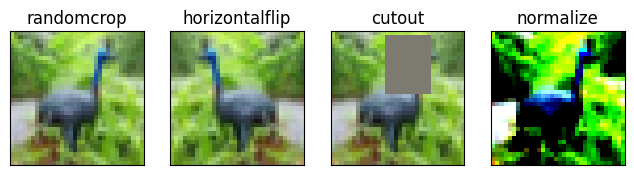

In [8]:
from utils import visualize_cifar_augmentation

aug_train = TransformedDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [9]:
SEED = 8
BATCH_SIZE = 512

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [10]:
from models.resnet import ResNet18
from models.resnet import get_summary

get_summary(ResNet18(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## One Cycle Policy

In [11]:
# Put the model on selected device
model = ResNet18().to(device)

# Optimization algorithm to update the weights
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.02E-02


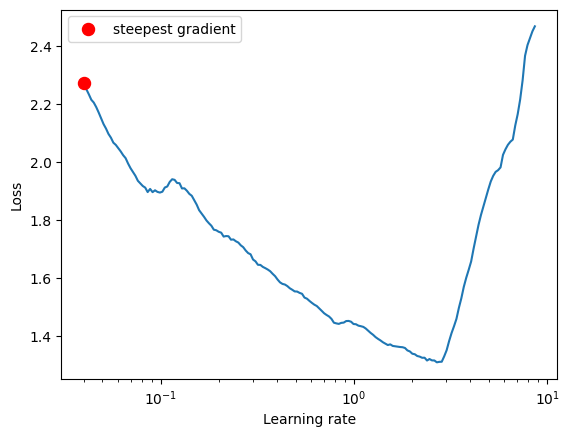

In [12]:
# LR finder
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## Parameters

In [13]:
EPOCHS = 20

MAX_LR = 4.02E-02    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

## Model Training and Testing

In [14]:
from training_utils import train, test, get_lr

In [15]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=EPOCHS,
                                                pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.4290 Batch_id=97 Accuracy=35.33: 100%|██████████| 98/98 [00:13<00:00,  7.30it/s]


Test set: Average loss: 0.0030, Accuracy: 4553/10000 (45.53%)

Epoch 2


Train: Loss=1.0031 Batch_id=97 Accuracy=59.07: 100%|██████████| 98/98 [00:13<00:00,  7.32it/s]


Test set: Average loss: 0.0021, Accuracy: 6181/10000 (61.81%)

Epoch 3


Train: Loss=0.7156 Batch_id=97 Accuracy=69.87: 100%|██████████| 98/98 [00:13<00:00,  7.31it/s]


Test set: Average loss: 0.0018, Accuracy: 6900/10000 (69.00%)

Epoch 4


Train: Loss=0.5798 Batch_id=97 Accuracy=76.16: 100%|██████████| 98/98 [00:13<00:00,  7.32it/s]


Test set: Average loss: 0.0020, Accuracy: 6853/10000 (68.53%)

Epoch 5


Train: Loss=0.5668 Batch_id=97 Accuracy=79.53: 100%|██████████| 98/98 [00:13<00:00,  7.32it/s]


Test set: Average loss: 0.0017, Accuracy: 7228/10000 (72.28%)

Epoch 6


Train: Loss=0.5059 Batch_id=97 Accuracy=82.98: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s]


Test set: Average loss: 0.0012, Accuracy: 7991/10000 (79.91%)

Epoch 7


Train: Loss=0.3842 Batch_id=97 Accuracy=85.44: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s]


Test set: Average loss: 0.0020, Accuracy: 7189/10000 (71.89%)

Epoch 8


Train: Loss=0.4007 Batch_id=97 Accuracy=87.62: 100%|██████████| 98/98 [00:13<00:00,  7.34it/s]


Test set: Average loss: 0.0013, Accuracy: 8004/10000 (80.04%)

Epoch 9


Train: Loss=0.2938 Batch_id=97 Accuracy=89.53: 100%|██████████| 98/98 [00:13<00:00,  7.34it/s]


Test set: Average loss: 0.0013, Accuracy: 8043/10000 (80.43%)

Epoch 10


Train: Loss=0.2497 Batch_id=97 Accuracy=91.07: 100%|██████████| 98/98 [00:13<00:00,  7.35it/s]


Test set: Average loss: 0.0013, Accuracy: 7997/10000 (79.97%)

Epoch 11


Train: Loss=0.2346 Batch_id=97 Accuracy=92.69: 100%|██████████| 98/98 [00:13<00:00,  7.35it/s]


Test set: Average loss: 0.0011, Accuracy: 8194/10000 (81.94%)

Epoch 12


Train: Loss=0.2159 Batch_id=97 Accuracy=93.92: 100%|██████████| 98/98 [00:13<00:00,  7.34it/s]


Test set: Average loss: 0.0012, Accuracy: 8243/10000 (82.43%)

Epoch 13


Train: Loss=0.1163 Batch_id=97 Accuracy=94.89: 100%|██████████| 98/98 [00:13<00:00,  7.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8396/10000 (83.96%)

Epoch 14


Train: Loss=0.1272 Batch_id=97 Accuracy=95.85: 100%|██████████| 98/98 [00:13<00:00,  7.31it/s]


Test set: Average loss: 0.0011, Accuracy: 8468/10000 (84.68%)

Epoch 15


Train: Loss=0.1054 Batch_id=97 Accuracy=96.64: 100%|██████████| 98/98 [00:13<00:00,  7.32it/s]


Test set: Average loss: 0.0014, Accuracy: 8174/10000 (81.74%)

Epoch 16


Train: Loss=0.0649 Batch_id=97 Accuracy=97.44: 100%|██████████| 98/98 [00:13<00:00,  7.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8562/10000 (85.62%)

Epoch 17


Train: Loss=0.0631 Batch_id=97 Accuracy=97.94: 100%|██████████| 98/98 [00:13<00:00,  7.29it/s]


Test set: Average loss: 0.0011, Accuracy: 8554/10000 (85.54%)

Epoch 18


Train: Loss=0.0465 Batch_id=97 Accuracy=98.72: 100%|██████████| 98/98 [00:13<00:00,  7.31it/s]


Test set: Average loss: 0.0010, Accuracy: 8703/10000 (87.03%)

Epoch 19


Train: Loss=0.0358 Batch_id=97 Accuracy=98.91: 100%|██████████| 98/98 [00:13<00:00,  7.31it/s]


Test set: Average loss: 0.0009, Accuracy: 8793/10000 (87.93%)

Epoch 20


Train: Loss=0.0269 Batch_id=97 Accuracy=99.23: 100%|██████████| 98/98 [00:13<00:00,  7.30it/s]


Test set: Average loss: 0.0009, Accuracy: 8823/10000 (88.23%)



## Visualize Train and Test - Loss and Accuracies

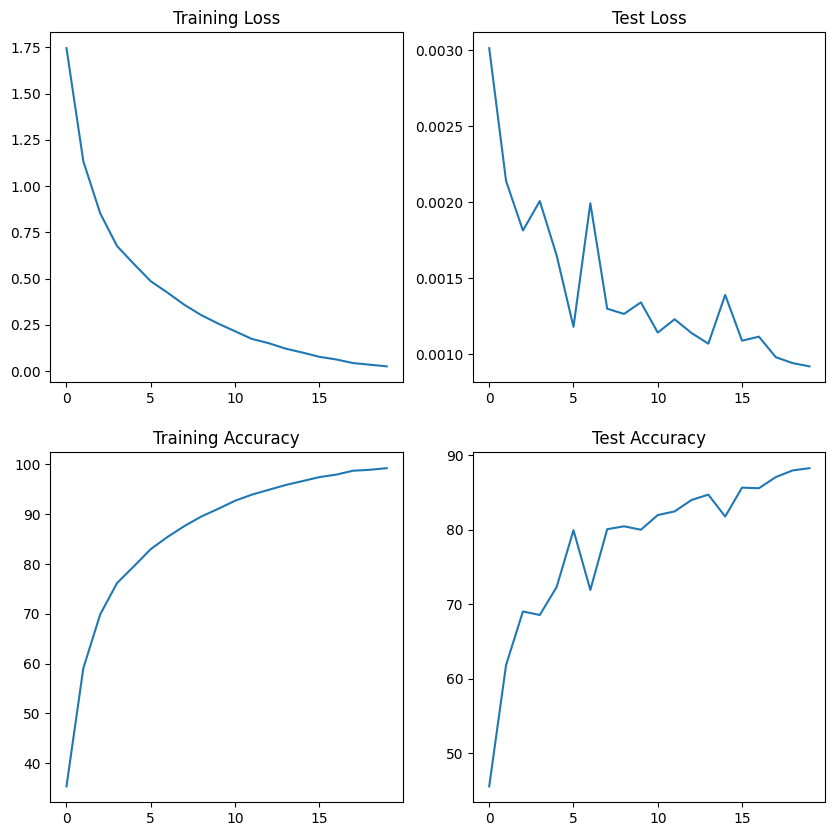

In [16]:
# Print loss and accuracy
from utils import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

---

## Visualize the One Cycle Policy Implementation

Text(0.5, 1.0, 'Training Learning Rate')

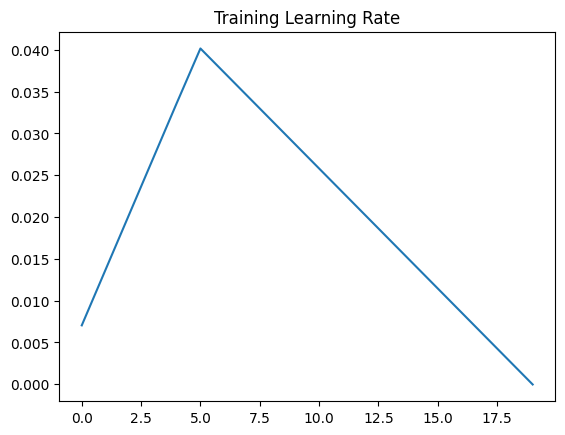

In [17]:
import matplotlib.pyplot as plt

plt.plot(learning_rates)
plt.title("Training Learning Rate")

---

## Visualize Misclassified Images

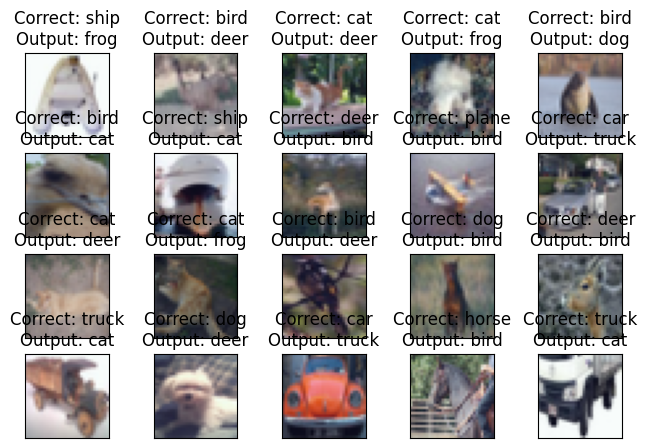

In [18]:
from utils import get_misclassified_data
from utils import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=20)

---

## GradCam
- GradCam can be used to check the class activations on an image. It also works on an Adversarial images
- It can also be used to check if the network is biased
- Here, GradCam is used to check the misclassified class activations on the images
- Activations of the four blocks of ResNet18 are displayed below

### Layer-4
The heatmap highlights the region of the image, which is considered to be **classified object** by the network

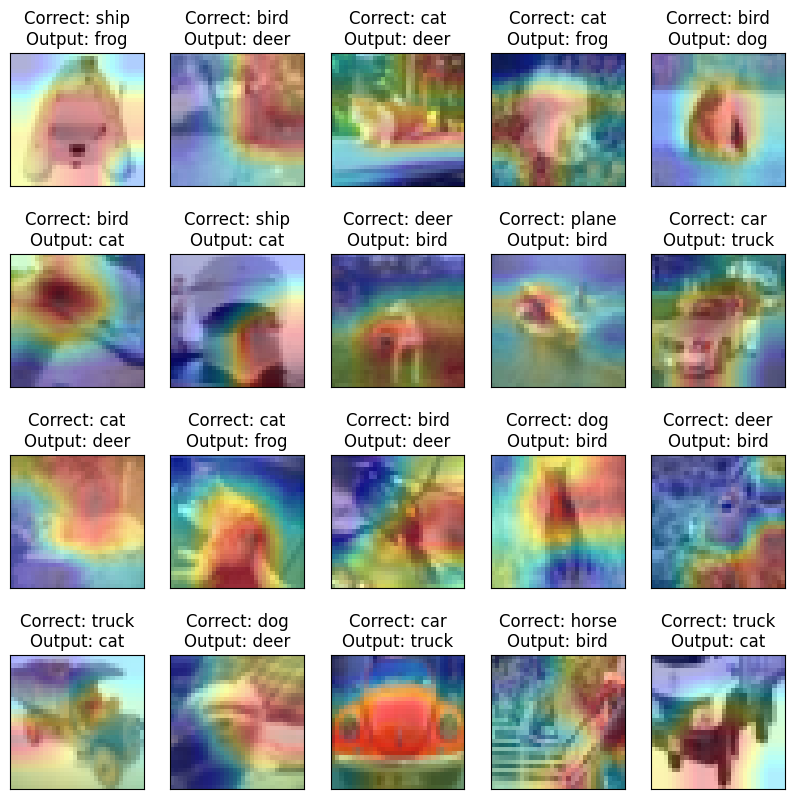

In [19]:
from utils import display_gradcam_output

target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None

display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

### Layer-3
The heatmap highlights the region of the image, which is considered to be **parts of the classified object** by the network

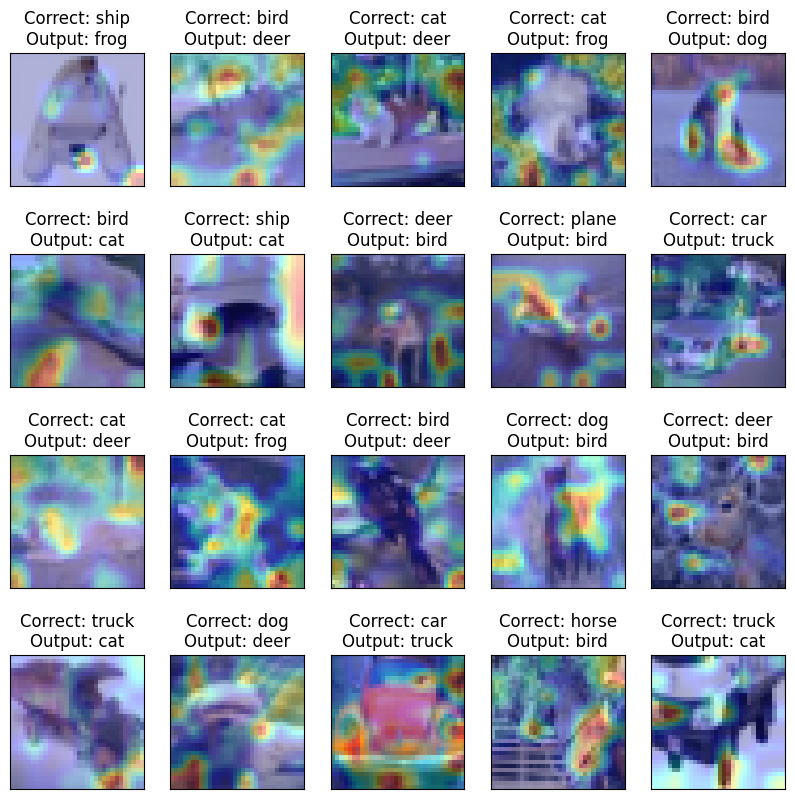

In [20]:
target_layers = [model.layer3[-2]]
display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

### Layer-2
The heatmap highlights the region of the image, which is considered to be **textures and patterns of the classified object** by the network

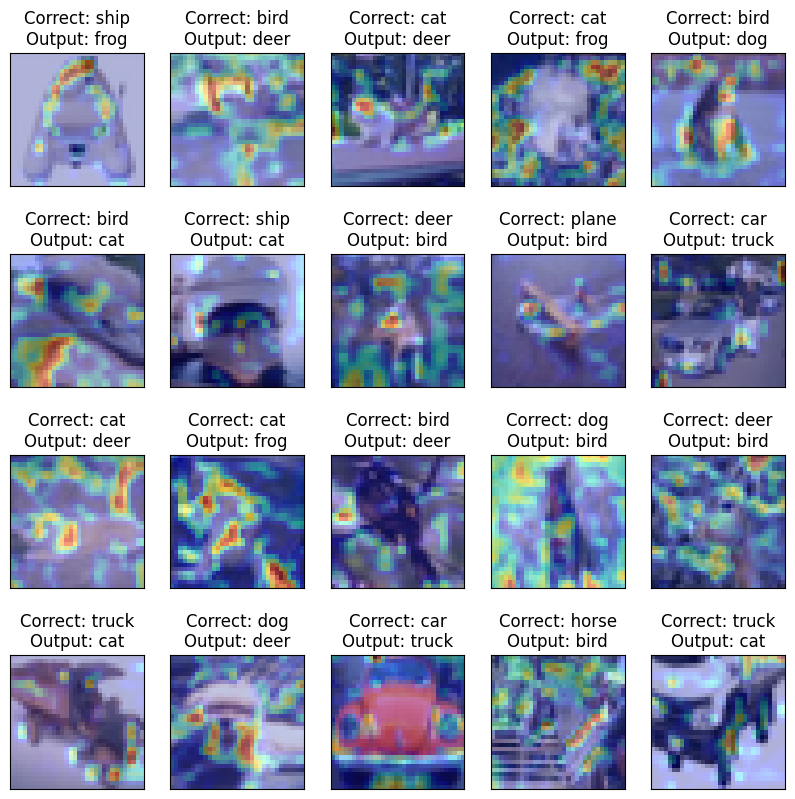

In [21]:
target_layers = [model.layer2[-2]]
display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

### Layer-1
The heatmap highlights the region of the image, which is considered to be **edges and gradients of the classified object** by the network

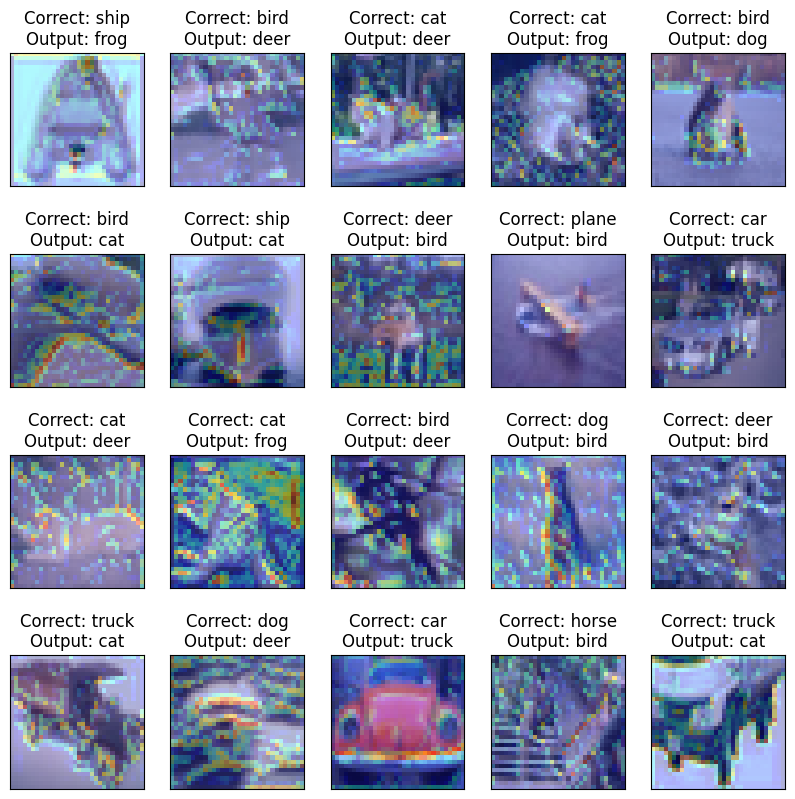

In [22]:
target_layers = [model.layer1[-2]]
display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

---

## Confusion Matrix

In [23]:
from utils import visualize_confusion_matrix

visualize_confusion_matrix(classes, device, model, test_loader)

NameError: name 'confusion_matrix' is not defined

---

## Save/Load Model

In [ ]:
# Save Model
torch.save(model, './model.pth')

In [ ]:
# # Load Model
# model = Session10Net()
# # # model.load_state_dict(torch.load('./model.pth'))
# # # torch.load('./model.pth', map_location=torch.device('cpu'))
# torch.load('./data/model_2.pth', map_location=torch.device('cuda'))
# model.eval()